In [73]:
from tqdm import tqdm_notebook
from matplotlib import rcParams
import matplotlib.pyplot as pl
from warnings import filterwarnings
import pickle
import numpy as np
import glob
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [89]:
dataDir='/accounts/ekarakoy/DEV-ALL/UNCERTAINTIES/UNCPY/UNC_notebooks/Systematic_Error_Sensitivity/Data/'
filelist = glob.glob(os.path.join(dataDir,'*AbsDif*'))

bands = [412, 443, 490, 510, 555, 670, 765, 865]
bandNums = {k: v for k, v in zip(bands, range(8))}

mainStr='L3mDataDictAbsDiff_band'
sfx = '_0p1p.pkl'

In [90]:
with open('./Data/L3mBaselineDict.pkl', 'rb') as f:
    bslDict = pickle.load(f)

In [91]:
def PlotData(dataDict, rngDict, ylbl="Freq", relative=True,
             xlbl="$Wm^{-2}\mu m^{-1} sr^{-1}$"):
    f,axs = pl.subplots(ncols=2, nrows=3, figsize=(12,16))
    factor = 1
    if relative:
        factor = 100
    for band, ax in zip(bands[:-2], axs.ravel()):
        
        data = dataDict[band].compressed() * factor
        ax.hist(data, normed=True, histtype='stepfilled', range=rngDict[band], bins=100,
                log=False, alpha=0.9)
        ax.set_title(band, fontsize=subPlotFontTitleSize)
        if band > 510:
            ax.set_xlabel(xlbl, fontsize=16)
        if band in [412, 490, 555]:
            ax.set_ylabel(ylbl, fontsize=16)
    if bandNum < 700:
        axs.ravel()[bandNums[bandNum]].hist(dataDict[bandNum].compressed() * 100,
                                            normed=True, histtype='step', linewidth=2,
                                            color='k', range=rngDict[bandNum], bins=100)
    return f, axs

In [92]:
def GetAccumDicts(indep=True):
    AccumDataDicts = dict.fromkeys(bands[:-2])
    #AccumRelDataDicts = dict.fromkeys(bands[:-2])
    for wvl in tqdm_notebook(bands[:-2]):
        AccumDataDicts[wvl] = np.zeros_like(bslDict['Rrs'][412])
        for pwvl in tqdm_notebook(bands):
            with open('%s%s%d%s' %(dataDir, mainStr, bandNums[pwvl], sfx),'rb') as f:
                data = pickle.load(f)['Rrs'][wvl] / bslDict['Rrs'][wvl]
            if indep:
                AccumDataDicts[wvl] += np.power(data,2)
            else:
                AccumDataDicts[wvl] += data
        if indep:
            AccumDataDicts[wvl] = np.sqrt(AccumDataDicts[wvl])
        else:
            AccumDataDicts[wvl] = AccumDataDicts[wvl] * 100
    return AccumDataDicts


In [93]:
% matplotlib inline
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['axes.formatter.limits'] = (-2, 2)
subPlotFontTitleSize = 18
figureTitleFontSize = 20
otherFontSize = 16
filterwarnings("ignore")

In [94]:
ADD = GetAccumDicts(indep=True)

In [96]:
np.percentile(data, [2.5, 97.5])

array([ 0.01281974,  0.32011148])

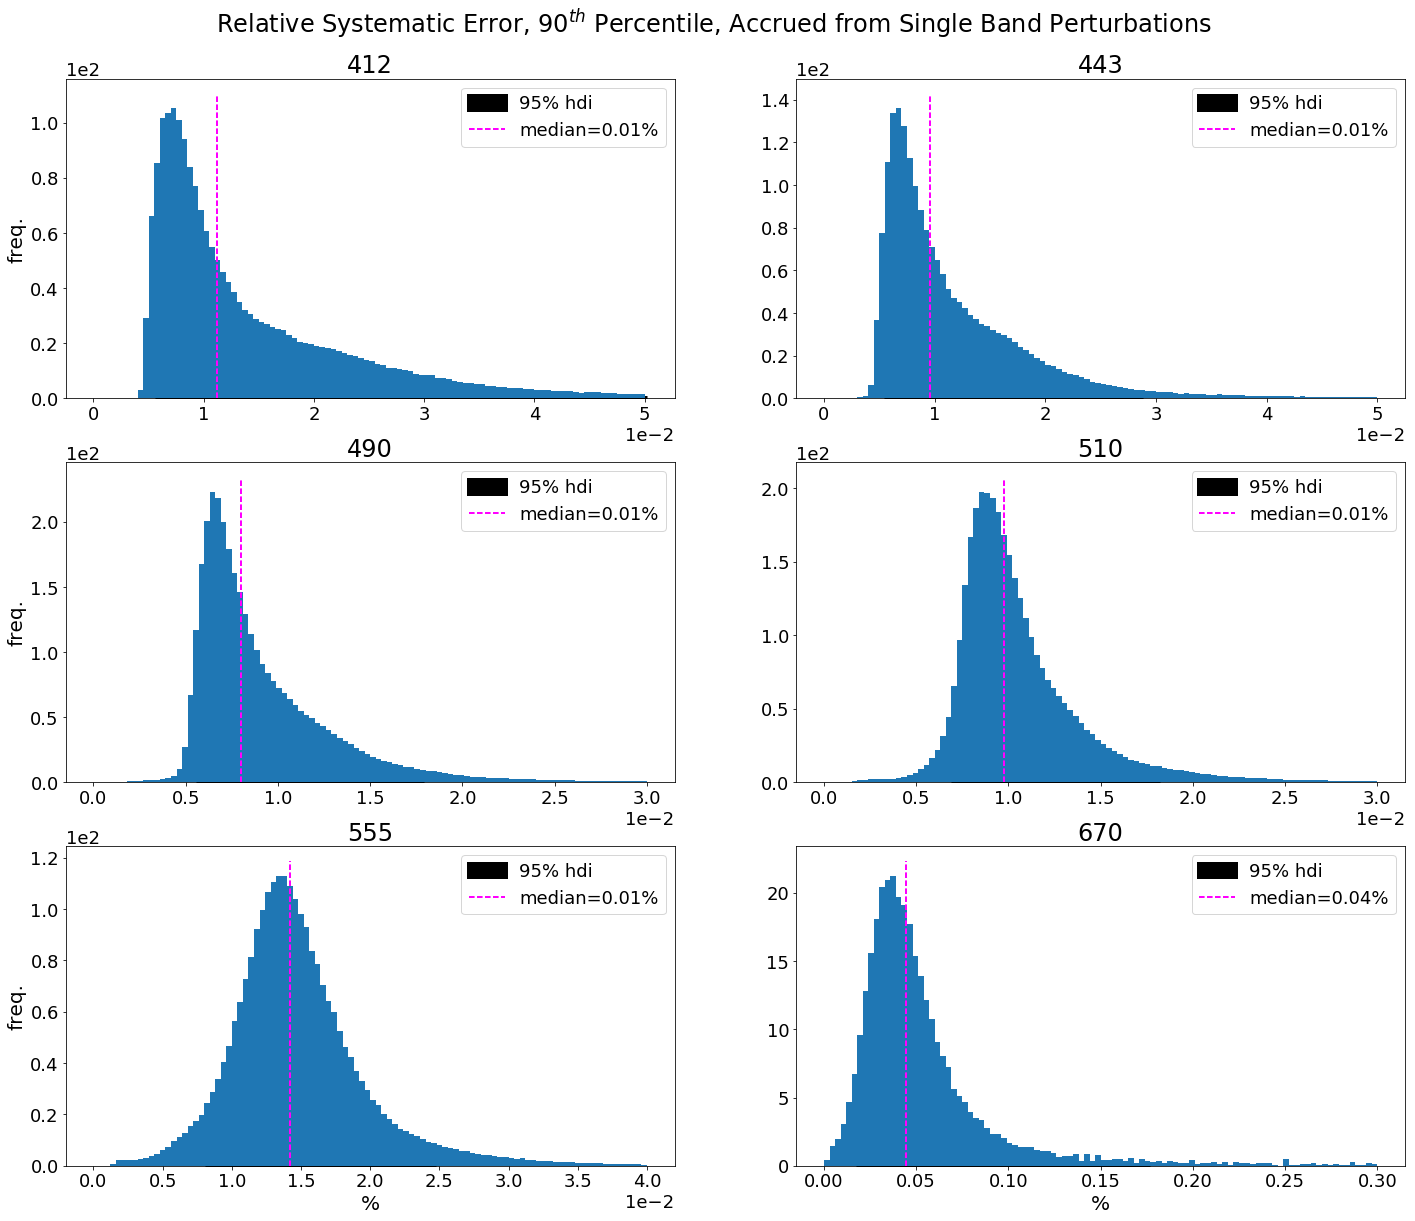

In [102]:
f,axs = pl.subplots(ncols=2, nrows=3, figsize=(24,20))
f.suptitle('Relative Systematic Error, $90^{th}$ Percentile, Accrued from Single Band Perturbations',
           y=0.93, fontsize=24)
bandRng = {412: (0, 5e-2), 443: (0, 5e-2), 490: (0, 3e-2),
           510: (0, 3e-2), 555: (0, 4e-2), 670: (0, .3)}

for band, ax in zip(bands[:-2], axs.ravel()):
    data = ADD[band].compressed()
    #data = data[:round(0.9 * data.size)]
    hdiLo, med, hdiHi = np.percentile(data,[5, 50, 95])
    ax.hist(data, bins=100, range=bandRng[band], normed=True);
    ax.set_title(band, fontsize=24)
    if band in [412, 490, 555]:
        ax.set_ylabel('freq.', fontsize=20)
    if band in [555, 670]:
        ax.set_xlabel('%', fontsize=20)
    ax.fill_betweenx([ax.get_ylim()[0]]*2, hdiLo, hdiHi, label='95% hdi', color='k', linewidth=5)
    ax.vlines(med,*ax.get_ylim(), label='median=%.2f%%' % med, color='magenta', linestyle='--', linewidth=2)
    ax.legend(fontsize=18)
f.savefig('/accounts/ekarakoy/Desktop/SB_prop_quadrat.png',dpi=300, format='png')